# Similarity explanations for imagenet

In this notebook we apply the similarity explanation method to a ResNet model pretrained on the Imagenet dataset. 
We use a subset of the imagenet dataset including 1000 random samples as train set for the explainer. The train set is builded by picking 100 random images for each of the following classes:

* 'stingray'

* 'trilobite'

* 'centipede'

* 'slug'

* 'snail'

* 'Rhodesian ridgeback'

* 'beagle'

* 'golden retriever'

* 'sea lion'

* 'espresso' 

The test set contains 50 random samples, 5 for each of the classes above. The data set is stored in a public google storage bucket and can be fetched using the utility function `fetch_imagenet10`. 

Given an input image of interest picked from the test set, the similarity explanation method used here aims to find images in the train dataset that are similar to the image of interest according to "how the model sees them", meaning that the similarity metric makes use of the gradients of the model's loss function with respect to the model's parameters. 

The similarity explanation tool is implemented with both pytorch and tensorflow backends. In this example, we will use the tensorflow backend.

A more detailed description of the method can be found [here](link_to_method). The implementation follows  [Charpiat et al., 2019](https://papers.nips.cc/paper/2019/file/c61f571dbd2fb949d3fe5ae1608dd48b-Paper.pdf) and  [Hanawa et al. 2021](https://arxiv.org/pdf/2006.04528.pdf).

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from alibi.datasets import load_cats
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from alibi.datasets import fetch_imagenet_10
from alibi.explainers.similarity.grad import GradientSimilarity

In [3]:
def plot_similar(ds, expls, int_to_str, figsize=(20, 20)):
    """Plots original instances and similar instances.
    """
    fig, axes = plt.subplots(5, 6, figsize=figsize, sharex=False)
    for j in range(len(ds)):
        d = ds[j]
        axes[j, 0].imshow(d['x'])
        label_orig = int_to_str[d['y']].split(',')[0]
        if len(label_orig) > 16:
            label_orig = label_orig[:13] + '...'
        pred_orig = int_to_str[d['pred']].split(',')[0]
        if len(pred_orig) > 16:
            pred_orig = pred_orig[:13] + '...'
        if j == 0:
            axes[j, 0].set_title("Original instance \n" + 
                                 "================ \n " + 
                                 f"Label: {label_orig} \n" + 
                                 f"Prediction: {pred_orig} ")
        else:
            axes[j, 0].set_title(f"Label: {label_orig} \n" +
                                 f"Prediction: {pred_orig} ")
        for i in range(expls.data['most_similar'].shape[0]):
            label_sim = int_to_str[d['y_sim'][i]].split(',')[0]
            if len(label_sim) > 16:
                label_sim = label_sim[:13] + '...'
            pred_sim = int_to_str[d['preds_sim'][i]].split(',')[0]
            if len(pred_sim) > 16:
                pred_sim = pred_sim[:13] + '...'
            most_similar = expls.data['most_similar'][j][i]
            axes[j, i + 1].imshow(most_similar, cmap='gray')
            if j == 0:
                axes[j, i + 1].set_title(f"{i+1}{appendInt(i+1)} most similar instance \n" + 
                                         "================ \n " + 
                                         f"Label: {label_sim} \n" + 
                                         f"Prediction: {pred_sim}")
            else:
                axes[j, i + 1].set_title(f"Label: {label_sim} \n" + 
                                         f"Prediction: {pred_sim}")
    plt.show()


def plot_distributions(ds, expls, int_to_str, figsize=(20, 20)):
    """Plots original instances and scores distributions per class.
    """

    fig, axes = plt.subplots(5, 2, figsize=figsize, sharex=False)

    for i in range(len(ds)):
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim, 
                                       'preds_sim': preds_sim, 
                                       'scores': expls.data['scores'][i]})

        axes[i, 0].imshow(d['x'])
        if i == 0:
            axes[i, 0].set_title("Original instance \n " + 
                                 "=================== \n " + 
                                 f"Label: {d['y']} - {int_to_str[d['y']]}  \n" + 
                                 f"Prediction: {d['pred']} - {int_to_str[d['pred']].split(',')[0]} ")
        else:
            axes[i, 0].set_title(f"Label: {d['y']} - {int_to_str[d['y']].split(',')[0]}  \n" + 
                                 f"Prediction: {d['pred']} - {int_to_str[d['pred']].split(',')[0]} ")        
        df_y = df_ditribution.groupby('y_sim')['scores'].mean().sort_values(ascending=False)
        df_y.plot(kind='bar', ax=axes[i, 1])
        if i == 0:
            axes[i, 1].set_title("Averaged scores for each true class in reference set \n" + 
                                 "================================== ")

    fig.tight_layout()
    plt.show()

def appendInt(num):
    """Converts integer into cardials (ex. 1 -> 1st, 2 -> 2nd, etc.)
    """
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'

## Load data

Loading and preparing the MNIST data set.

In [4]:
imagenet10 = fetch_imagenet_10()

In [5]:
X_train, y_train = imagenet10['trainset']
X_test, y_test = imagenet10['testset']
int_to_str = imagenet10['int_to_str_labels']
y_train = to_categorical(y_train, num_classes=1000)
y_test = to_categorical(y_test, num_classes=1000)

Label: 6 - stingray


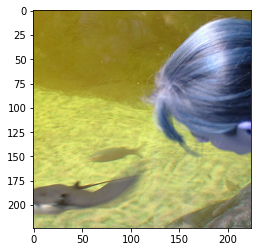

In [6]:
i = 0
label = y_train.argmax(axis=1)[i]
print(f"Label: {label} - {int_to_str[label]}")
plt.imshow(X_train[i])

## Load model

Load a pretrained tensorflow model with a ResNet architecture trained on the Imagenet dataset.

In [7]:
model = ResNet50(weights='imagenet')
preds = model(X_test).numpy().argmax(axis=1)
acc = accuracy_score(y_test.argmax(axis=1), preds)
print('Test accuracy: ', acc)

2022-05-10 15:24:51.607178: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-10 15:24:52.253186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14777 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:01:00.0, compute capability: 7.5
2022-05-10 15:24:53.392852: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


Test accuracy:  0.7


## Find similaraties 

Initializing a `GradientSimilarity` explainer instance

In [8]:
gsm = GradientSimilarity(model, categorical_crossentropy, precompute_grads=False, sim_fn='grad_cos')

Fitting the explainer on the train data

In [9]:
gsm.fit(X_train, y_train)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': False,
              'backend_name': 'tensorflow',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

Selecting 5 random classes out of 10 and 1 random instance per class from the test set (5 test instances in total).

In [10]:
idxs_samples = np.array([np.random.choice(range(5 * i, 5 * i + 5)) for i in range(10)])
idxs_samples = np.random.choice(idxs_samples, 5, replace=False)

X_sample, y_sample = X_test[idxs_samples], y_test[idxs_samples]
preds = model(X_sample).numpy().argmax(axis=1)

Getting the most similar instance for the each of the 5 test samples

In [11]:
expls = gsm.explain(X_sample, y_sample)

Building a dictionary for each sample for visualization purposes. 
Each dictionary contains
* The original text document `x` (not the embedding representation).
* The corresponding label `y`.
* The corresponding model's prediction `pred`.
* The reference instances ordered by similarity `x_sim`.
* The corresponding reference labels ordered by similarity `y_sim`.
* The corresponding model's predictions for the reference set `preds_sim`.

## Visualizations

In [15]:
ds = []
for j in range(len(X_sample)):
    y_sim = y_train[expls.data['ordered_indices'][j]].argmax(axis=1)
    X_sim = X_train[expls.data['ordered_indices'][j]]
    preds_sim = model(X_sim).numpy().argmax(axis=1)

    d = {'x': X_sample[j], 
         'y': y_sample[j].argmax(), 
         'pred':preds[j],
         'x_sim': X_sim,
         'y_sim': y_sim, 
         'preds_sim': preds_sim}
    ds.append(d)

### Most similar instances

Showing the 5 most similar instances for each of the test instances, ordered from the most similar to the least similar.

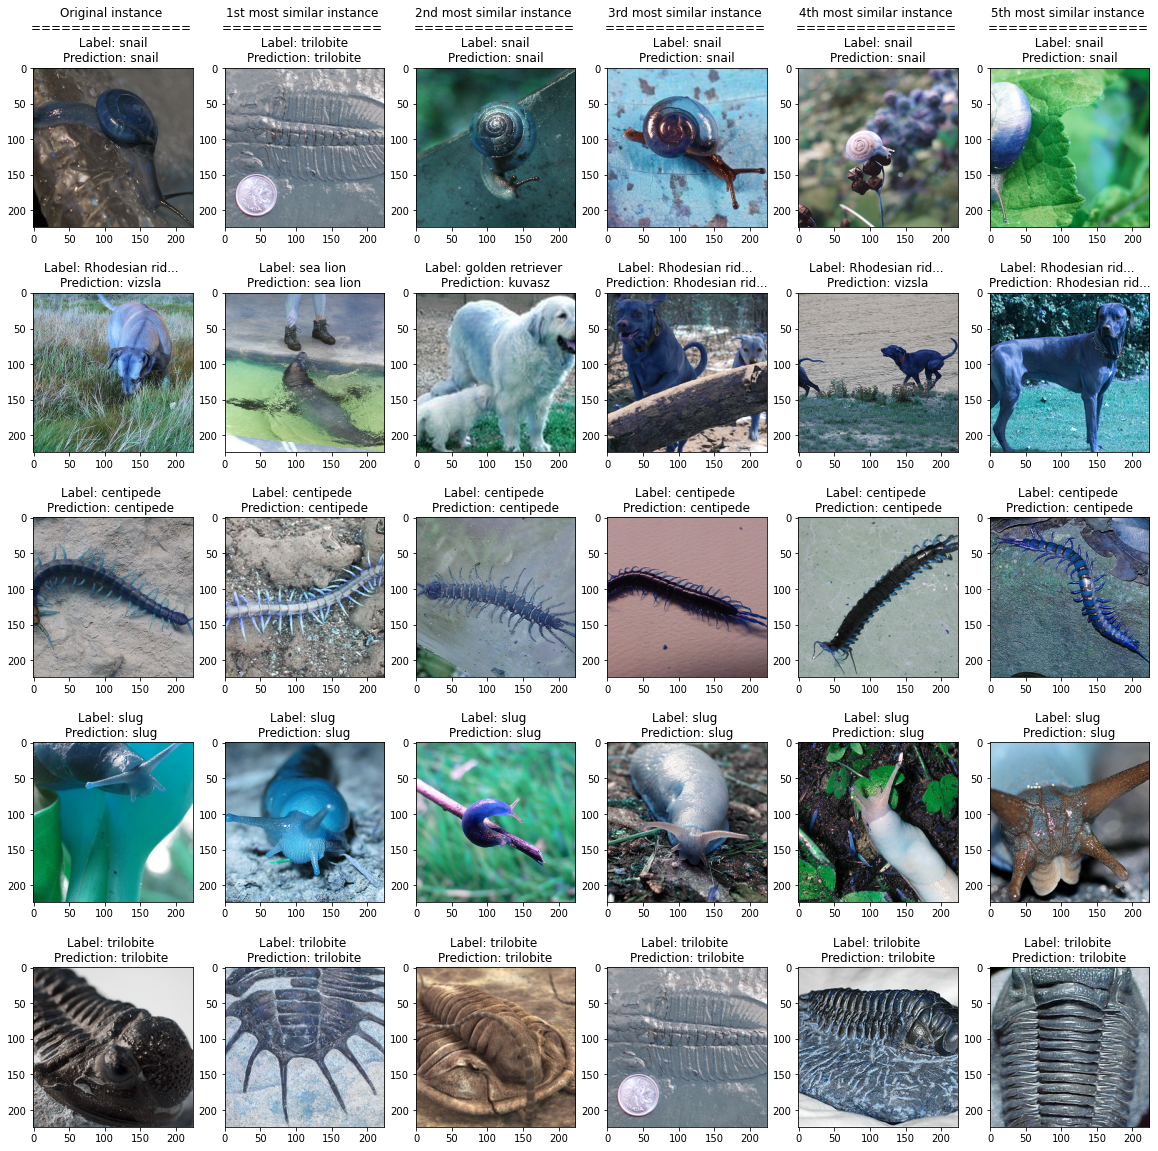

In [16]:
plot_similar(ds, expls, int_to_str)

### Most similar labels distributions 

Showing the average similarity scores for each group of instances in the reference set belonging to the same true class. It can be seen that the higher score corresponds to the class of the original instance, as expected.

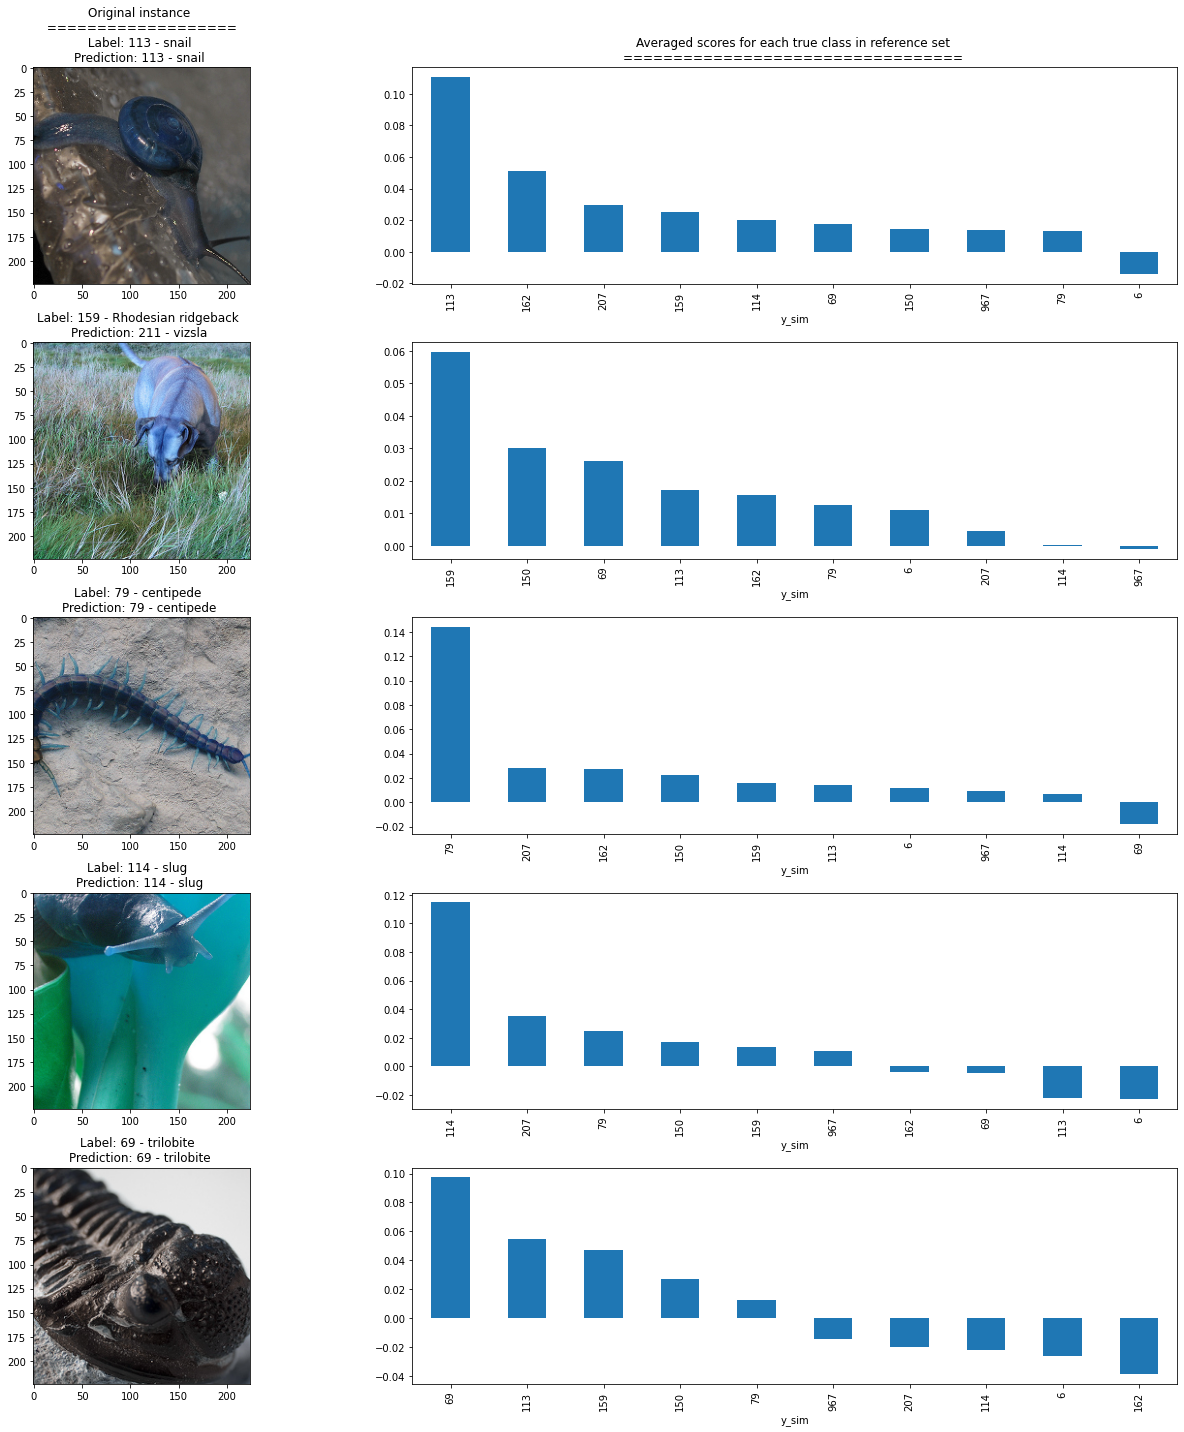

In [17]:
plot_distributions(ds, expls, int_to_str)